In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from torch import nn, Tensor
import time
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if not os.path.exists("./models"):
    os.mkdir("./models")

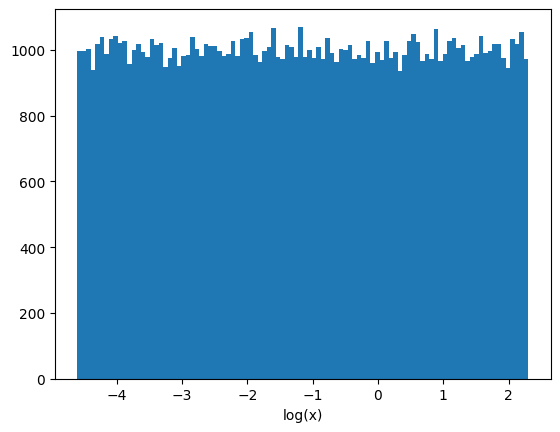

In [2]:
def sample_log_uniform(low, high, size, device=None):
    """
    low, high: scalars (floats), low > 0
    size: tuple, e.g. (B,)
    """
    u = torch.rand(size, device=device)
    log_low = torch.log(torch.tensor(low, device=device))
    log_high = torch.log(torch.tensor(high, device=device))
    return torch.exp(log_low + u * (log_high - log_low)).to(device)


def sample_prior(B, device=None):
    gamma = sample_log_uniform(0.05, 0.5, (B, 1), device)
    R0 = sample_log_uniform(0.5, 5.0, (B, 1), device)
    beta = R0 * gamma
    return torch.cat([beta, gamma], dim=1).to(device)

samples = sample_log_uniform(0.01, 10.0, (100_000,))
plt.hist(torch.log(samples).numpy(), bins=100)
plt.xlabel("log(x)")
plt.show()

tensor([[0.2172, 0.0873],
        [0.1445, 0.0776]])


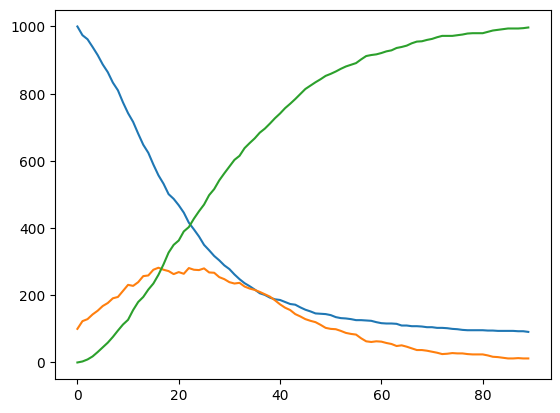

In [3]:
def simulate(phi, sir, T):
    S, I, R = sir
    S = torch.zeros(phi.shape[0], device=phi.device) + S
    I = torch.zeros(phi.shape[0], device=phi.device) + I
    R = torch.zeros(phi.shape[0], device=phi.device) + R
    N = S + I + R
    states = torch.zeros(phi.shape[0], T, 3, device=phi.device)
    for t in range(0, T):
        states[:, t, 0] = S
        states[:, t, 1] = I
        states[:, t, 2] = R

        p_inf = 1 - torch.exp(-phi[:, 0] * I / N)
        p_rec = 1 - torch.exp(-phi[:, 1])

        new_inf = torch.binomial(S, p_inf)
        new_rec = torch.binomial(I, p_rec)

        S = S - new_inf
        I = I + new_inf - new_rec
        R = R + new_rec

    states[:, T-1, 0] = S
    states[:, T-1, 1] = I
    states[:, T-1, 2] = R
    return states        
    
sir = (1000, 100, 0)
# phi = torch.tensor([[5, 5],
#                     [10, 5]])
phi = sample_prior(2)
print(phi)
x_0, x_1 = simulate(phi, sir, 90).cpu()
S, I, R = x_0[:, 0], x_0[:, 1], x_0[:, 2]
plt.plot(S)
plt.plot(I)
plt.plot(R)
# S, I, R = x_1[:, 0], x_1[:, 1], x_1[:, 2]
# plt.plot(S)
# plt.plot(I)
# plt.plot(R)

torch.Size([2, 90, 3]) torch.Size([2, 5])


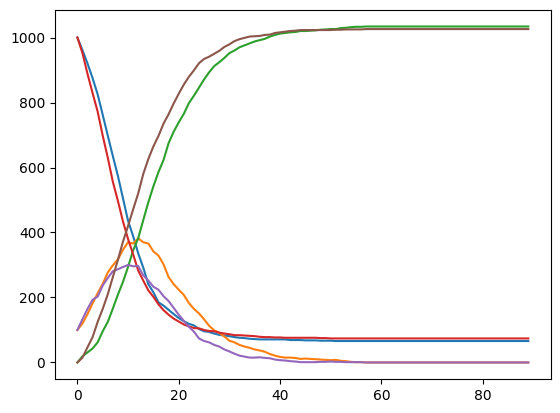

In [4]:
def summary(x):
    S, I, R = x[:, :, 0], x[:, :, 1], x[:, :, 2]
    I_peak, t_peak = I.max(dim=1)

    t_peak = t_peak / S.shape[1]
    t_peak = torch.transpose(t_peak.expand(1, t_peak.shape[0]), 0, 1)
    
    I_peak_norm = I_peak / I.sum(dim=1)
    I_peak_norm = torch.transpose(I_peak_norm.expand(1, I_peak_norm.shape[0]), 0, 1)

    I_integral = (I / I[:, 0, None]).sum(dim=1) / I.shape[1]
    I_integral = torch.transpose(I_integral.expand(1, I_integral.shape[0]), 0, 1)

    R_final = R[:, -1] / R.sum(dim=1)
    R_final = torch.transpose(R_final.expand(1, R_final.shape[0]), 0, 1)

    S_final = S[:, -1] / S.sum(dim=1)
    S_final = torch.transpose(S_final.expand(1, S_final.shape[0]), 0, 1)


    return torch.cat([t_peak, I_peak_norm, I_integral, R_final, S_final], dim=1)

phi = sample_prior(2)
x = simulate(phi, sir, 90)
print(x.shape, summary(x).shape)
# print(summary(x))
# bull = False
# for i in range(x.shape[0]):
#     if bull:
#         break
#     for j in range(i+1, x.shape[0]):
#         if abs(summary(x)[i, 0:2] - summary(x)[j, 0:2]).sum() + abs(summary(x)[i, 3] - summary(x)[j, 3]) < 0.01:
#             for k in [i, j]: 
#                 S, I, R = x[k, :, 0], x[k, :, 1], x[k, :, 2]
#                 plt.plot(S)
#                 plt.plot(I)
#                 plt.plot(R)
#             bull = True
#             break

for i in range(x.shape[0]):
    S, I, R = x[i, :, 0], x[i, :, 1], x[i, :, 2]
    plt.plot(S)
    plt.plot(I)
    plt.plot(R)

In [5]:
class CondFlow(nn.Module):
    def __init__(self, phi_dim, x_dim, h):
        super().__init__()
        self.dim = phi_dim
        self.net = nn.Sequential(
            nn.Linear(1 + x_dim + phi_dim, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, phi_dim)
        )
    
    def forward(self, t, x, phi):
        return self.net(torch.cat((t, x, phi), dim=-1))
    
    def step(self, phi, x, t_start, t_end):
        t_start = t_start.view(1, 1).expand(phi.shape[0], 1)
        t_end = t_end.view(1, 1).expand(phi.shape[0], 1)
        
        t_mid = (t_end + t_start) / 2
        phi_mid = phi + self.forward(t=t_start, x=x, phi=phi) * (t_mid - t_start)
        return  phi + self.forward(t=t_mid, x=x, phi=phi_mid) * (t_end - t_start)

model = CondFlow(2, 5, 16)
beta, gamma = 5, 5
sir = (1000, 100, 0)

phi = torch.tensor([[beta, gamma]])
x = simulate(phi, sir, 90)
s = summary(x)
t = torch.tensor([[0.0]])
model(t=t, x=s, phi=phi)

tensor([[0.1178, 0.0020]], grad_fn=<AddmmBackward0>)

Epoch: 0, Loss: 1.0975
Epoch: 200, Loss: 0.1120
Epoch: 400, Loss: 0.0704
Epoch: 600, Loss: 0.0650
Epoch: 800, Loss: 0.0632
Epoch: 1000, Loss: 0.0820


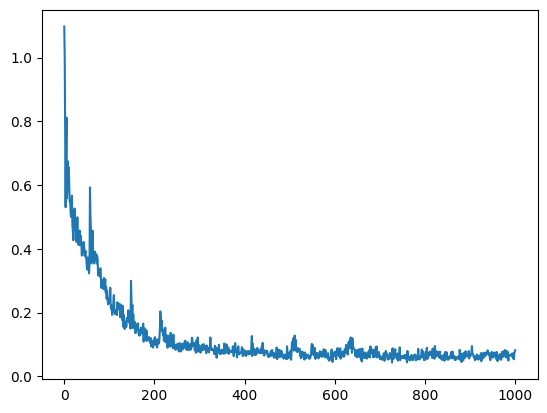

In [6]:
def train(model, 
          sim_parameters, 
          optimizer, 
          loss_fn, 
          epochs=2000,
          path="./models",
          show_every=None, 
          show_loss=False):
    
    model.train()
    sir = sim_parameters["sir"]
    T_max = sim_parameters["T_max"]

    losses = []
    min_loss = torch.inf

    if not show_every is None:
        show_loss = True

    
    for i in range(epochs+1):
        phi_1 = sample_prior(1000).to(device)

        s = summary(simulate(phi_1, sir, T_max)).to(device)
        phi_0 = torch.randn_like(phi_1).to(device)
        t = torch.rand(phi_1.shape[0], 1).to(device)

        # print(phi_1.shape, t.shape, s.shape)
        phi_t = (1 - t) * phi_0 + t * phi_1
        dphi_t = phi_1 - phi_0

        v = model(t=t, x=s, phi=phi_t)
        loss = loss_fn(v, dphi_t)
        losses.append(loss.detach().item())

        if loss < min_loss:
            torch.save(model.state_dict(), path)
        
        if show_loss and i % show_every == 0:
            print(f"Epoch: {i}, Loss: {losses[i]:.4f}")#, Time: {(time.time() - s):.2f}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

model = CondFlow(2, 5, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss = torch.nn.MSELoss()
sim_parameters = {"sir": (1000, 100, 0),
                  "T_max": 90}

datetime = time.strftime("%Y-%m-%d_%H_%M_%S")
path = f"./models/SIR_{datetime}.pth.tar.gz" 

losses = train(model, sim_parameters, optimizer, loss, path=path, epochs=1000, show_every=200)
plt.plot(losses)

Epoch: 0, Loss: 0.0572
Epoch: 100, Loss: 0.0403
Epoch: 200, Loss: 0.0414
Epoch: 300, Loss: 0.0389
Epoch: 400, Loss: 0.0559
Epoch: 500, Loss: 0.0539


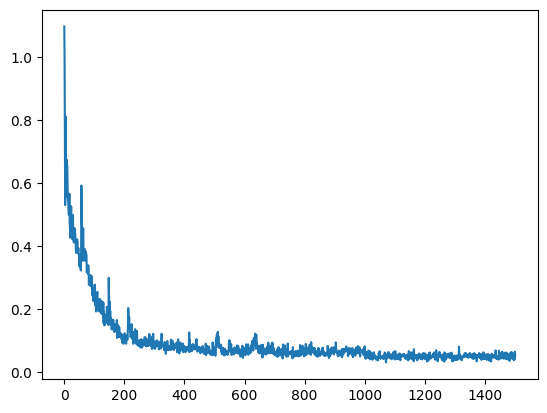

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses += train(model, sim_parameters, optimizer, loss, epochs=500, path=path, show_every=100)
plt.plot(losses)

tensor([[0.0780, 0.1021]])
tensor([[0.0814, 0.1255]], grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0292, 0.3808, 0.0159, 0.0103]]) tensor([[0.0000, 0.0486, 0.2286, 0.0140, 0.0108]])


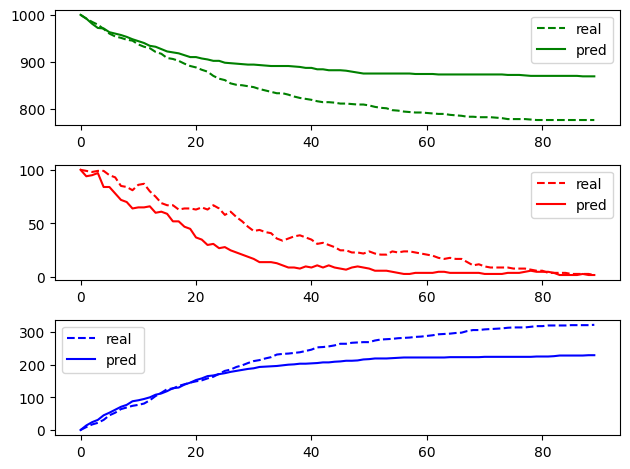

In [8]:
sir = (1000, 100, 0)
phi = sample_prior(1)
# phi = torch.tensor([[0.0734, 0.0664]])
x = simulate(phi, sir, 90)
s = summary(x).to(device)

n_steps = 10
time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
phi_pred = 0.1*torch.randn_like(phi).to(device)
for i in range(n_steps):
    phi_pred = model.step(phi=phi_pred, x=s, t_start=time_steps[i], t_end=time_steps[i+1])

print(phi)
print(phi_pred)

x_real = simulate(phi, sir, 90).detach().cpu()
x_pred = simulate(phi_pred, sir, 90).detach().cpu()

print(summary(x_real), summary(x_pred))

S_real, I_real, R_real = x_real[0, :, 0], x_real[0, :, 1], x_real[0, :, 2]
S_pred, I_pred, R_pred = x_pred[0, :, 0], x_pred[0, :, 1], x_pred[0, :, 2]

_, ax = plt.subplots(3, 1)
ax[0].plot(S_real, linestyle="--", color="green", label="real")
ax[0].plot(S_pred, color="green", label="pred")
ax[1].plot(I_real, linestyle="--", color="red", label="real")
ax[1].plot(I_pred, color="red", label="pred")
ax[2].plot(R_real, linestyle="--", color="blue", label="real")
ax[2].plot(R_pred, color="blue", label="pred")
[ax[i].legend() for i in range(3)]
plt.tight_layout()

In [9]:
# sir = (1000, 100, 0)
# eps = 0.01

# phi = sample_prior(1)
# x = simulate(phi, sir, 90)
# s_phi = summary(x).to(device)

# posterior = []

# while len(posterior) < 1000:
#     new_phi = sample_prior(1)
#     x = simulate(new_phi, sir, 90)
#     s = summary(x).to(device)
#     if abs(s - s_phi).sum() < eps:
#         posterior.append(new_phi)
# posterior = torch.cat(posterior)
# plt.scatter(posterior[:, 0], posterior[:, 1])



tensor([[0.2661, 0.3022],
        [0.3494, 0.0964],
        [0.3379, 0.4339],
        [0.4811, 0.4732]])


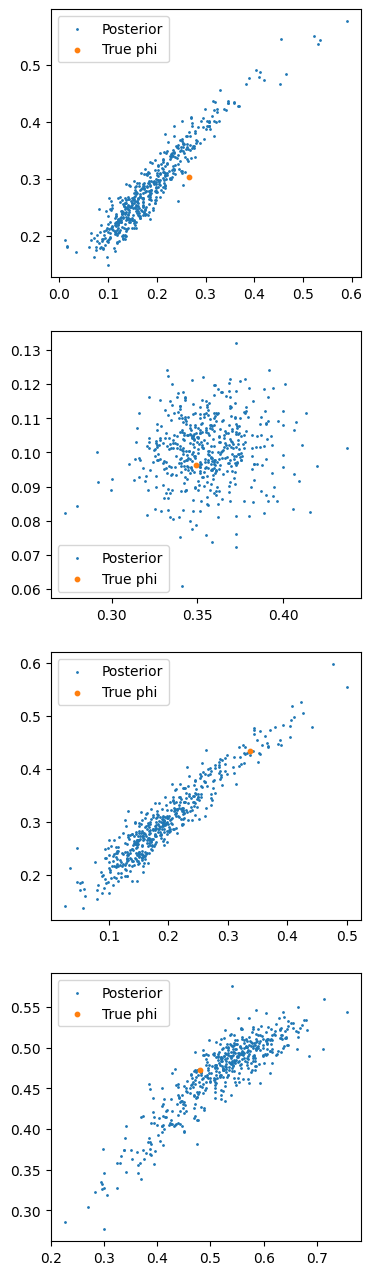

In [10]:
def sample_posterior(phi, s, n_steps=10, n_samples=1000):
    model.eval()
    posterior = []
    time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
    for i in range(n_samples):
        pred_phi = torch.randn_like(phi).to(device)
        for i in range(n_steps):
            pred_phi = model.step(phi=pred_phi, x=s, t_start=time_steps[i], t_end=time_steps[i+1])
        posterior.append(pred_phi[:, None, :])
    return torch.cat(posterior, dim=1).detach()

sir = (1000, 100, 0)

phi = sample_prior(4).to(device)
# phi = torch.tensor([[0.2216, 0.0523]])
x = simulate(phi, sir, 90)
s = summary(x).to(device)
print(phi)

_, ax = plt.subplots(phi.shape[0], 1, figsize=(4, 4 * phi.shape[0]))
posterior = sample_posterior(phi, s, n_steps=32, n_samples=500).cpu()
for i in range(phi.shape[0]):
    # print(posterior)
    # ax[i].scatter(torch.log(posterior[:, 0]), torch.log(posterior[:, 1]), s=1, label=f"Posterior")
    # ax[i].scatter(torch.log(phi[:, 0]), torch.log(phi[:, 1]), s=10, label=f"True phi")
    ax[i].scatter(posterior[i, :, 0], posterior[i, :, 1], s=1, label=f"Posterior")
    ax[i].scatter(phi[i, 0].cpu(), phi[i, 1].cpu(), s=10, label=f"True phi")
    ax[i].legend()

Text(0.5, 1.0, 'gamma posterior')

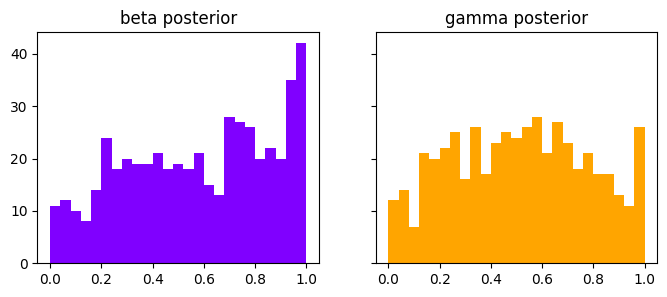

In [11]:
def sample_posterior(phi, s, n_steps=10, n_samples=1000):
    model.eval()
    posterior = []
    time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
    for i in range(n_samples):
        pred_phi = torch.randn_like(phi).to(device)
        for i in range(n_steps):
            pred_phi = model.step(phi=pred_phi, x=s, t_start=time_steps[i], t_end=time_steps[i+1])
        posterior.append(pred_phi[:, None, :])
    return torch.cat(posterior, dim=1).detach()


sir = (1000, 100, 0)
phi = sample_prior(500).to(device)
# phi = torch.tensor([[0.2145, 0.0758],
#         [0.0278, 0.0501],
#         [0.2631, 0.1156],
#         [1.2791, 0.3799]])

x = simulate(phi, sir, 90)
s = summary(x).to(device)

posterior = sample_posterior(phi, s, n_steps=32, n_samples=100)
ranks = (posterior < phi[:, None, :]).sum(dim=-2) / posterior.shape[1]

_, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))
ax[0].hist(ranks[:, 0], bins=25, color="#8000ff")
ax[0].set_title("beta posterior")
ax[1].hist(ranks[:, 1], bins=25, color="orange")
ax[1].set_title("gamma posterior")